In [1]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import shutil

In [2]:
# Set up the paths - adjust these according to your directory structure
data_dir = "C:/Users/subha/data/cityscapes"
output_dir = "C:/Users/subha/data/cityscapes/output"

In [3]:
# Check if the directories exist
print(f"Checking directory paths...")
print(f"Data directory exists: {os.path.exists(data_dir)}")
print(f"Data directory contents: {os.listdir(data_dir) if os.path.exists(data_dir) else 'N/A'}")

Checking directory paths...
Data directory exists: True
Data directory contents: ['gtFine', 'gtFine_trainvaltest', 'gtFine_trainvaltest.zip', 'leftImg8bit', 'leftImg8bit_trainvaltest', 'leftImg8bit_trainvaltest.zip', 'license (2).txt', 'license.txt', 'output', 'README', 'README (2)']


In [4]:
# Create output directories

os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks/train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks/val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks/test'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'visualizations'), exist_ok=True)

In [5]:
# Define Cityscapes class mappings
# Original Cityscapes has 30+ classes
cityscapes_id_to_name = {
    0: 'unlabeled',
    1: 'ego vehicle',
    2: 'rectification border',
    3: 'out of roi',
    4: 'static',
    5: 'dynamic',
    6: 'ground',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
    -1: 'license plate'
}

In [6]:
# Define our new class mapping (6 classes + background)
# 0: Background (catch-all for unlabeled and other classes)
# 1: Road
# 2: Building
# 3: Vehicle (cars, trucks, buses)
# 4: Person (person, rider)
# 5: Vegetation
# 6: Sky
new_mapping = {
    0: 0,  # unlabeled -> background
    1: 0,  # ego vehicle -> background
    2: 0,  # rectification border -> background
    3: 0,  # out of roi -> background
    4: 0,  # static -> background
    5: 0,  # dynamic -> background
    6: 0,  # ground -> background
    7: 1,  # road -> road
    8: 0,  # sidewalk -> background
    9: 0,  # parking -> background
    10: 0, # rail track -> background
    11: 2, # building -> building
    12: 0, # wall -> background
    13: 0, # fence -> background
    14: 0, # guard rail -> background
    15: 0, # bridge -> background
    16: 0, # tunnel -> background
    17: 0, # pole -> background
    18: 0, # polegroup -> background
    19: 0, # traffic light -> background
    20: 0, # traffic sign -> background
    21: 5, # vegetation -> vegetation
    22: 0, # terrain -> background
    23: 6, # sky -> sky
    24: 4, # person -> person
    25: 4, # rider -> person
    26: 3, # car -> vehicle
    27: 3, # truck -> vehicle
    28: 3, # bus -> vehicle
    29: 3, # caravan -> vehicle
    30: 3, # trailer -> vehicle
    31: 3, # train -> vehicle
    32: 3, # motorcycle -> vehicle
    33: 3, # bicycle -> vehicle
    -1: 0, # license plate -> background
}


In [7]:
# Our new class names
new_class_names = {
    0: 'background',
    1: 'road',
    2: 'building',
    3: 'vehicle',
    4: 'person',
    5: 'vegetation',
    6: 'sky'
}

In [8]:
# Function to process Cityscapes dataset
def process_cityscapes(data_dir, output_dir, split='train', sample_size=None):
    """
    Process Cityscapes dataset to create segmentation masks based on simplified classes
    
    Args:
        data_dir: Root directory of Cityscapes dataset
        output_dir: Directory to save processed data
        split: Data split ('train', 'val', 'test')
        sample_size: Number of samples to process (None for all)
    """
    # Input paths
    img_dir = os.path.join(data_dir, f'leftImg8bit/{split}')
    gt_dir = os.path.join(data_dir, f'gtFine/{split}')
    
    # Check if directories exist
    if not os.path.exists(img_dir):
        print(f"ERROR: Image directory not found: {img_dir}")
        return {'edge_cases': {}, 'class_pixels': {}, 'total_images': 0}
    
    if not os.path.exists(gt_dir):
        print(f"ERROR: Ground truth directory not found: {gt_dir}")
        return {'edge_cases': {}, 'class_pixels': {}, 'total_images': 0}
    
    
    
     
    # Output paths
    out_img_dir = os.path.join(output_dir, f'images/{split}')
    out_mask_dir = os.path.join(output_dir, f'masks/{split}')
    
    # Get list of cities
    cities = os.listdir(img_dir)
    print(f"Found {len(cities)} cities for {split} split: {', '.join(cities)}")
    
    # Stats for edge cases
    edge_cases = defaultdict(int)
    class_pixels = defaultdict(int)
    
    
    
    
    
    
    
    
    # Process images for each city
    count = 0
    for city in cities:
        city_img_dir = os.path.join(img_dir, city)
        city_gt_dir = os.path.join(gt_dir, city)
        
        
                
        # Verify directories exist
        if not os.path.exists(city_img_dir):
            print(f"WARNING: Image directory for city {city} not found: {city_img_dir}")
            continue
            
        if not os.path.exists(city_gt_dir):
            print(f"WARNING: GT directory for city {city} not found: {city_gt_dir}")
            continue
            
            
        
        
        # Get image files
        img_files = sorted([f for f in os.listdir(city_img_dir) if f.endswith('leftImg8bit.png')])
        print(f"Found {len(img_files)} images for city {city}")
        
       
    
    
        # Sample if requested
        if sample_size is not None and count >= sample_size:
            break
        
        if sample_size is not None:
            img_files = img_files[:min(len(img_files), sample_size - count)]
        
        
        
        
        
        # Process each image
        for img_file in tqdm(img_files, desc=f"Processing {city}"):
            # Get corresponding label ID file
            base_name = img_file.replace('_leftImg8bit.png', '')
            gt_file = f"{base_name}_gtFine_labelIds.png"
            
            # Load image and label
            img_path = os.path.join(city_img_dir, img_file)
            gt_path = os.path.join(city_gt_dir, gt_file)
            
            if not os.path.exists(gt_path):
                print(f"Warning: GT file not found: {gt_path}")
                edge_cases['missing_gt'] += 1
                continue
                
                
            try:
            
            # Load image and GT
                img = Image.open(img_path)
                gt = np.array(Image.open(gt_path))
            
            # Create new mask with our class mapping
                new_mask = np.zeros_like(gt, dtype=np.uint8)
            
            # Apply class mapping
                for old_id, new_id in new_mapping.items():
                    new_mask[gt == old_id] = new_id
                
            # Check for any pixels with IDs not in our mapping
                unknown_pixels = np.sum(~np.isin(gt, list(new_mapping.keys())))
                if unknown_pixels > 0:
                    edge_cases['unknown_class_ids'] += 1
                # Set unknown pixels to background
                    new_mask[~np.isin(gt, list(new_mapping.keys()))] = 0
            
            # Count pixels per class
                for class_id in range(7):  # 0-6
                    pixel_count = np.sum(new_mask == class_id)
                    class_pixels[class_id] += pixel_count
            
            # Save processed image and mask
                out_img_path = os.path.join(out_img_dir, f"{city}_{base_name}.png")
                out_mask_path = os.path.join(out_mask_dir, f"{city}_{base_name}.png")
            
                img.save(out_img_path)
                Image.fromarray(new_mask).save(out_mask_path)
            
                count += 1
            
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                edge_cases['processing_error'] += 1
                
    print(f"Processed {count} images for {split} split")
    print(f"Class pixel counts: {dict(class_pixels)}")
    
    # Save stats
    stats = {
        'edge_cases': dict(edge_cases),
        'class_pixels': {new_class_names[k]: v for k, v in class_pixels.items()},
        'total_images': count
    }
    
    
    
        # Before saving to JSON, convert any NumPy types to standard Python types
    def convert_numpy_types(obj):
        if isinstance(obj, dict):
            return {k: convert_numpy_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(i) for i in obj]
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
        
        
    # Convert NumPy types before saving
    stats = convert_numpy_types(stats)
    
    # Save stats to JSON
    stats_path = os.path.join(output_dir, f'stats_{split}.json')
    with open(stats_path, 'w') as f:
        json.dump(stats, f, indent=4)
    print(f"Saved stats to {stats_path}")
    
    return stats

In [9]:
# Function to create visualizations (only if there are images)
def create_visualizations(output_dir, split='train', num_samples=5):
    """Create visualization of samples with original images and masks"""
    img_dir = os.path.join(output_dir, f'images/{split}')
    mask_dir = os.path.join(output_dir, f'masks/{split}')
    viz_dir = os.path.join(output_dir, 'visualizations')
    
    # Check if directories exist and have files
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        print(f"Visualization directories not found. Skipping visualization for {split}.")
        return
    
    img_files = os.listdir(img_dir)
    if not img_files:
        print(f"No images found in {img_dir}. Skipping visualization for {split}.")
        return
    
    # Get sample images
    img_files = sorted(img_files)[:num_samples]
    if not img_files:
        print(f"No images to visualize for {split}.")
        return
    
    print(f"Creating visualizations for {len(img_files)} images from {split} split")
    
    plt.figure(figsize=(15, num_samples*5))
    
    # Create colormap for visualization
    colors = [
        [0, 0, 0],        # background - black
        [128, 64, 128],   # road - purple-ish blue
        [70, 70, 70],     # building - gray
        [0, 0, 142],      # vehicle - blue
        [220, 20, 60],    # person - red
        [107, 142, 35],   # vegetation - green
        [70, 130, 180]    # sky - light blue
    ]
    cmap = np.array(colors)
    
    for i, img_file in enumerate(img_files):
        # Load image and mask
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)
        
        if not os.path.exists(mask_path):
            print(f"Warning: Mask not found for {img_file}. Skipping.")
            continue
        
        try:
            img = np.array(Image.open(img_path))
            mask = np.array(Image.open(mask_path))
            
            # Create colored mask
            colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for class_id, color in enumerate(colors):
                colored_mask[mask == class_id] = color
            
            # Plot
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(img)
            plt.title(f"Original Image {i+1}")
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(mask, cmap='tab10', vmin=0, vmax=6)
            plt.title(f"Mask - {i+1}")
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            # Blend image with mask for visualization
            alpha = 0.5
            blended = (alpha * img + (1-alpha) * colored_mask).astype(np.uint8)
            plt.imshow(blended)
            plt.title(f"Overlay")
            plt.axis('off')
            
        except Exception as e:
            print(f"Error creating visualization for {img_file}: {e}")
    
    # Create a custom legend for the classes
    handles = [plt.Rectangle((0,0),1,1, color=[c/255 for c in colors[i]]) for i in range(len(new_class_names))]
    plt.figlegend(handles, new_class_names.values(), loc='lower center', ncol=len(new_class_names))
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, f'samples_{split}.png'))
    plt.show()


Processing train split with sample size 100...
Found 18 cities for train split: aachen, bochum, bremen, cologne, darmstadt, dusseldorf, erfurt, hamburg, hanover, jena, krefeld, monchengladbach, strasbourg, stuttgart, tubingen, ulm, weimar, zurich
Found 174 images for city aachen


Processing aachen: 100%|█████████████████████████████████████████████████████████████| 174/174 [09:01<00:00,  3.11s/it]


Found 96 images for city bochum


Processing bochum: 100%|███████████████████████████████████████████████████████████████| 96/96 [05:02<00:00,  3.16s/it]


Found 316 images for city bremen


Processing bremen: 100%|█████████████████████████████████████████████████████████████| 316/316 [16:15<00:00,  3.09s/it]


Found 154 images for city cologne


Processing cologne: 100%|████████████████████████████████████████████████████████████| 154/154 [07:50<00:00,  3.05s/it]


Found 85 images for city darmstadt


Processing darmstadt: 100%|████████████████████████████████████████████████████████████| 85/85 [04:11<00:00,  2.96s/it]


Found 221 images for city dusseldorf


Processing dusseldorf: 100%|█████████████████████████████████████████████████████████| 221/221 [12:23<00:00,  3.36s/it]


Found 109 images for city erfurt


Processing erfurt: 100%|█████████████████████████████████████████████████████████████| 109/109 [06:00<00:00,  3.31s/it]


Found 248 images for city hamburg


Processing hamburg: 100%|████████████████████████████████████████████████████████████| 248/248 [12:49<00:00,  3.10s/it]


Found 196 images for city hanover


Processing hanover: 100%|████████████████████████████████████████████████████████████| 196/196 [10:38<00:00,  3.26s/it]


Found 119 images for city jena


Processing jena: 100%|███████████████████████████████████████████████████████████████| 119/119 [06:49<00:00,  3.44s/it]


Found 99 images for city krefeld


Processing krefeld: 100%|██████████████████████████████████████████████████████████████| 99/99 [05:30<00:00,  3.34s/it]


Found 94 images for city monchengladbach


Processing monchengladbach: 100%|██████████████████████████████████████████████████████| 94/94 [05:15<00:00,  3.36s/it]


Found 365 images for city strasbourg


Processing strasbourg: 100%|█████████████████████████████████████████████████████████| 365/365 [20:15<00:00,  3.33s/it]


Found 196 images for city stuttgart


Processing stuttgart: 100%|██████████████████████████████████████████████████████████| 196/196 [10:56<00:00,  3.35s/it]


Found 144 images for city tubingen


Processing tubingen: 100%|███████████████████████████████████████████████████████████| 144/144 [07:55<00:00,  3.30s/it]


Found 95 images for city ulm


Processing ulm: 100%|██████████████████████████████████████████████████████████████████| 95/95 [05:08<00:00,  3.25s/it]


Found 142 images for city weimar


Processing weimar: 100%|█████████████████████████████████████████████████████████████| 142/142 [07:37<00:00,  3.22s/it]


Found 122 images for city zurich


Processing zurich: 100%|█████████████████████████████████████████████████████████████| 122/122 [06:37<00:00,  3.26s/it]


Processed 2975 images for train split
Class pixel counts: {0: 1306362141, 1: 2036416525, 2: 1260636120, 3: 459059194, 4: 74789586, 5: 879783988, 6: 221979646}
Saved stats to C:/Users/subha/data/cityscapes/output\stats_train.json
Completed train split: 2975 images
Creating visualizations for train split...
Creating visualizations for 3 images from train split


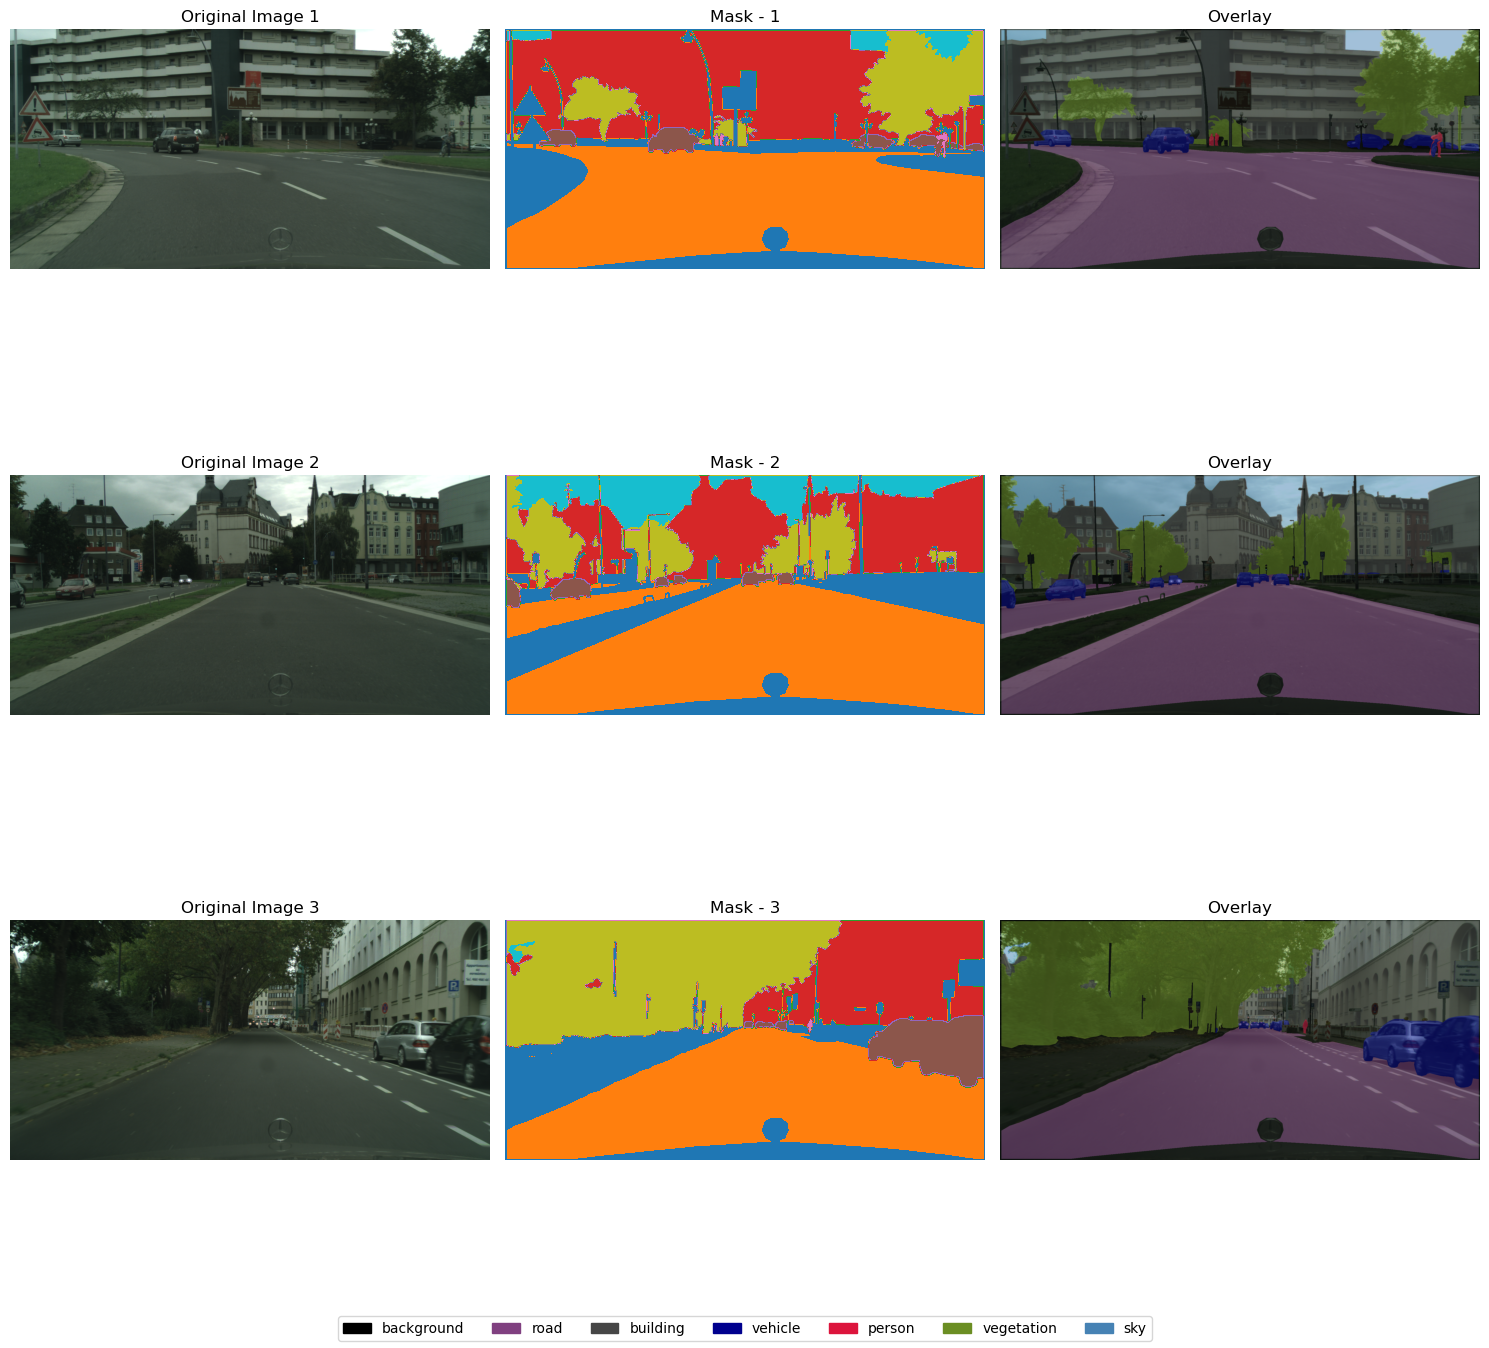

Class distribution (pixels):
  background: 1,306,362,141 pixels
  road: 2,036,416,525 pixels
  building: 1,260,636,120 pixels
  vehicle: 459,059,194 pixels
  person: 74,789,586 pixels
  vegetation: 879,783,988 pixels
  sky: 221,979,646 pixels

Data processing diagnostic complete!


In [11]:
# Process one split at a time
# We'll only process one split for troubleshooting
split = 'train'
# sample_size = 100  # Start with a smaller sample for troubleshooting

print(f"\nProcessing {split} split with sample size {sample_size}...")
stats = process_cityscapes(data_dir, output_dir, split, sample_size = None)
print(f"Completed {split} split: {stats['total_images']} images")

# If successful, try to create visualizations
if stats['total_images'] > 0:
    print(f"Creating visualizations for {split} split...")
    create_visualizations(output_dir, split, num_samples=3)
    
    # Print class distribution
    print(f"Class distribution (pixels):")
    for class_name, count in stats['class_pixels'].items():
        print(f"  {class_name}: {count:,} pixels")
    
    # Print edge cases if any
    if stats['edge_cases']:
        print(f"Edge cases encountered:")
        for case_type, count in stats['edge_cases'].items():
            print(f"  {case_type}: {count}")
else:
    print("No images were processed. Please check the dataset path and structure.")

print("\nData processing diagnostic complete!")

In [12]:
# Process the validation split
print("\nProcessing val split (all images)...")
val_stats = process_cityscapes(data_dir, output_dir, 'val')
print(f"Completed val split: {val_stats['total_images']} images")




Processing val split (all images)...
Found 3 cities for val split: frankfurt, lindau, munster
Found 267 images for city frankfurt


Processing frankfurt: 100%|██████████████████████████████████████████████████████████| 267/267 [13:13<00:00,  2.97s/it]


Found 59 images for city lindau


Processing lindau: 100%|███████████████████████████████████████████████████████████████| 59/59 [03:11<00:00,  3.25s/it]


Found 174 images for city munster


Processing munster: 100%|████████████████████████████████████████████████████████████| 174/174 [08:58<00:00,  3.10s/it]


Processed 500 images for val split
Class pixel counts: {0: 224209172, 1: 345264442, 2: 201005428, 3: 74574583, 4: 13889020, 5: 158868008, 6: 30765347}
Saved stats to C:/Users/subha/data/cityscapes/output\stats_val.json
Completed val split: 500 images
Creating visualizations for val split...


TypeError: create_visualizations() takes from 1 to 3 positional arguments but 4 were given

Creating visualizations for val split...
Creating visualizations for 3 images from val split


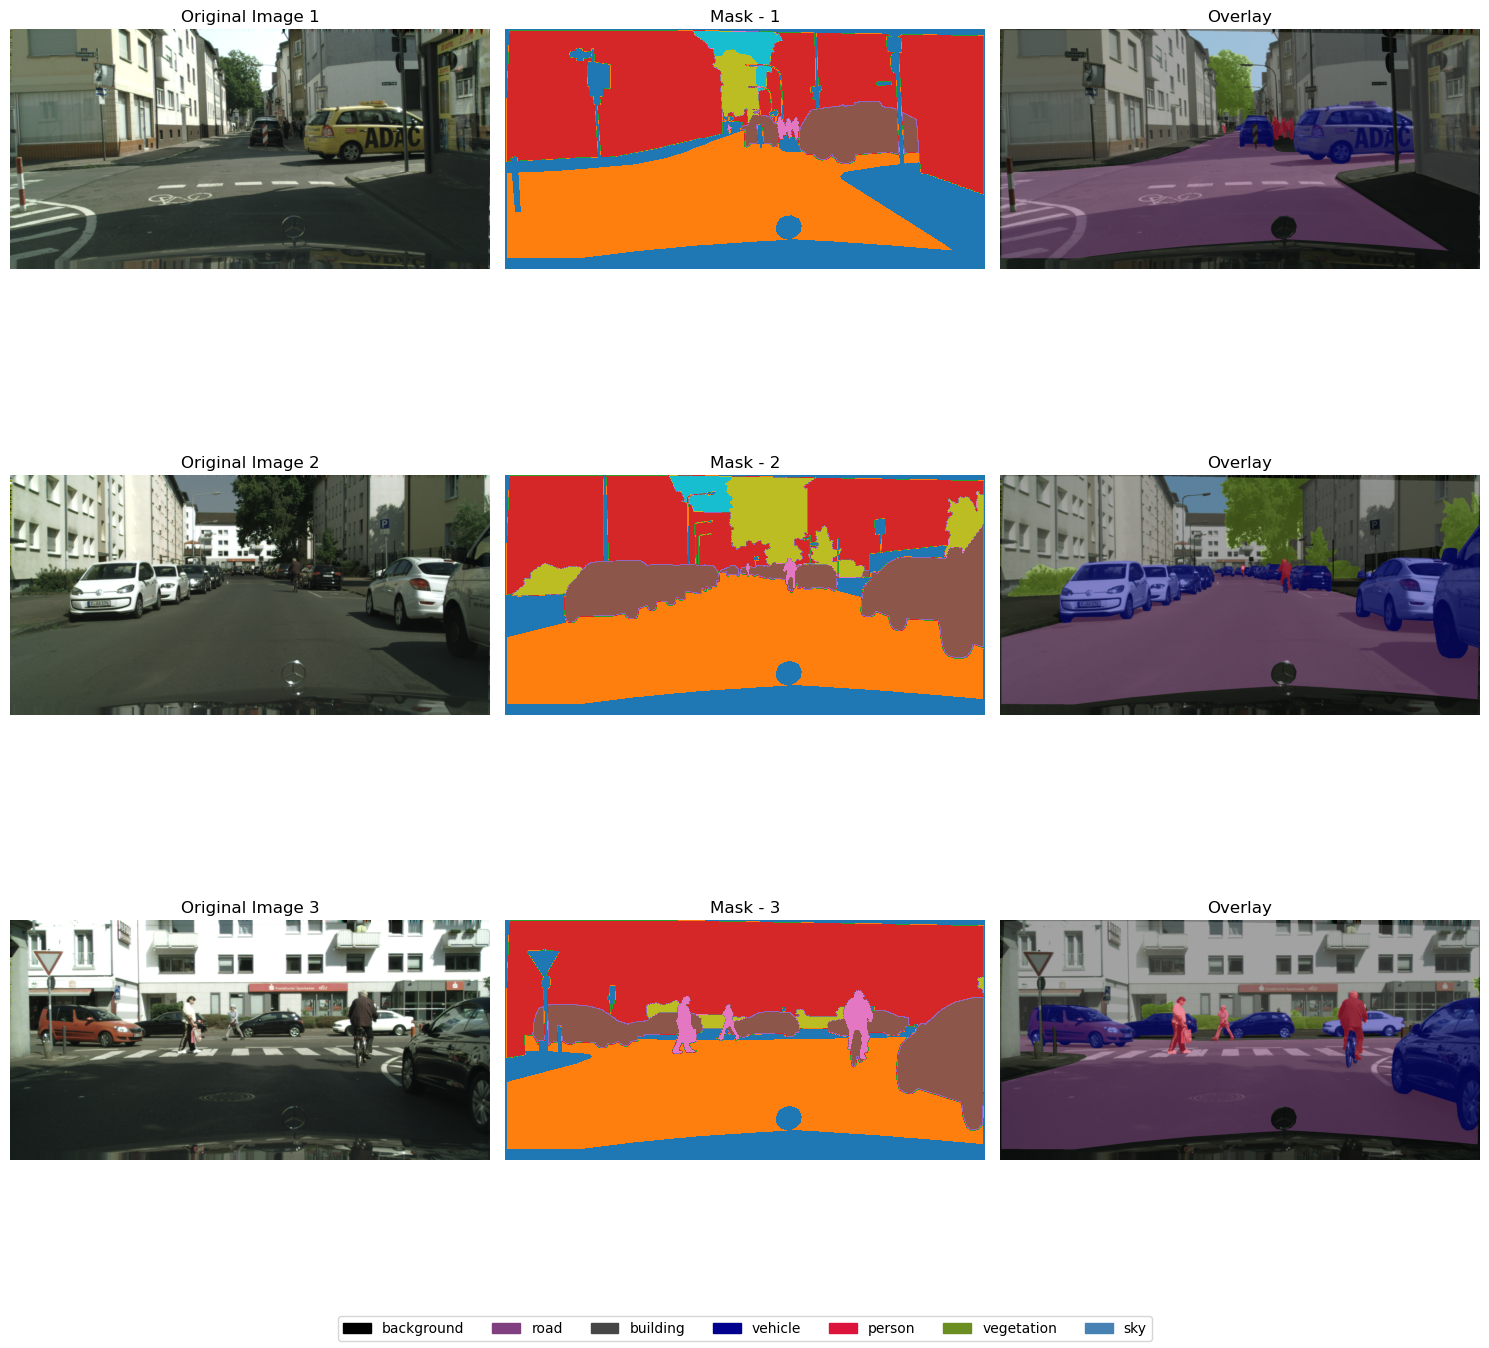

In [13]:
# Create visualizations for validation set
print("Creating visualizations for val split...")
create_visualizations(output_dir, 'val', 3)  # 3 sample images

In [ ]:
#Evaluations of masks produced

In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import json

In [17]:
def evaluate_mask_remapping(output_dir, split='train', num_samples=None):
    """
    Evaluate the quality of mask remapping for the specified split
    
    Args:
        output_dir: Directory containing processed masks
        split: Dataset split ('train', 'val', 'test')
        num_samples: Number of samples to evaluate (None for all)
        
    Returns:
        Dictionary with evaluation metrics
    """
    print(f"Evaluating mask remapping for {split} split...")
    
    # Load stats from JSON
    stats_path = os.path.join(output_dir, f'stats_{split}.json')
    with open(stats_path, 'r') as f:
        stats = json.load(f)
    
    # Let's print the keys to see what's available
    print("Available keys in stats file:", list(stats.keys()))
    
    # Find the correct key for class pixel counts
    class_counts_key = None
    for key in stats.keys():
        if "class" in key.lower() and "pixel" in key.lower():
            class_counts_key = key
            break
    
    if not class_counts_key:
        for key in stats.keys():
            if isinstance(stats[key], dict):
                print(f"Potential class counts in key '{key}':", stats[key])
    
    # Ask the user to specify the correct key if we can't find it
    if not class_counts_key:
        print("Please check the stats file and specify the key containing class pixel counts.")
        return None
    
    # Initialize metrics
    metrics = {
        'total_images': stats.get('total_images', 0),
        'class_distribution': stats[class_counts_key],
        'class_percentage': {},
        'class_balance_score': 0,
        'urban_class_coverage': 0
    }
    
    # Calculate total pixels
    total_pixels = sum(metrics['class_distribution'].values())
    
    # Calculate class percentages
    for cls, count in metrics['class_distribution'].items():
        metrics['class_percentage'][cls] = (count / total_pixels) * 100
    
    # Calculate class balance score (lower is better, 0 is perfect balance)
    expected_percentage = 100 / len(metrics['class_distribution'])
    balance_deviations = [abs(pct - expected_percentage) for pct in metrics['class_percentage'].values()]
    metrics['class_balance_score'] = sum(balance_deviations) / len(balance_deviations)
    
    # Calculate urban scene class coverage (road, building, vehicle)
    urban_classes = ['1', '2', '3']  # road, building, vehicle
    urban_coverage = sum(metrics['class_percentage'].get(cls, 0) for cls in urban_classes)
    metrics['urban_class_coverage'] = urban_coverage
    
    # Print evaluation results
    print("\nEvaluation results:")
    print(f"Total images processed: {metrics['total_images']}")
    print("\nClass distribution:")
    for cls, percentage in metrics['class_percentage'].items():
        class_name = {
            '0': 'background',
            '1': 'road',
            '2': 'building',
            '3': 'vehicle',
            '4': 'person',
            '5': 'vegetation',
            '6': 'sky'
        }.get(cls, cls)
        print(f"  {class_name}: {percentage:.2f}%")
    
    print(f"\nClass balance score: {metrics['class_balance_score']:.2f} (lower is better)")
    print(f"Urban class coverage: {metrics['urban_class_coverage']:.2f}%")
    
    # Create visualization of class distribution
    plt.figure(figsize=(10, 6))
    classes = list(metrics['class_percentage'].keys())
    class_names = [
        'background', 'road', 'building', 
        'vehicle', 'person', 'vegetation', 'sky'
    ][:len(classes)]  # Make sure we don't have more names than classes
    percentages = list(metrics['class_percentage'].values())
    
    plt.bar(class_names, percentages)
    plt.title(f'Class Distribution for {split} split')
    plt.xlabel('Class')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(output_dir, f'class_distribution_{split}.png')
    plt.savefig(plot_path)
    print(f"Saved class distribution plot to {plot_path}")
    
    return metrics

Evaluating mask remapping for train split...
Available keys in stats file: ['edge_cases', 'class_pixels', 'total_images']

Evaluation results:
Total images processed: 2975

Class distribution:
  background: 20.94%
  road: 32.64%
  building: 20.21%
  vehicle: 7.36%
  person: 1.20%
  vegetation: 14.10%
  sky: 3.56%

Class balance score: 8.84 (lower is better)
Urban class coverage: 0.00%
Saved class distribution plot to C:/Users/subha/data/cityscapes/output\class_distribution_train.png
Evaluating mask remapping for val split...
Available keys in stats file: ['edge_cases', 'class_pixels', 'total_images']

Evaluation results:
Total images processed: 500

Class distribution:
  background: 21.38%
  road: 32.93%
  building: 19.17%
  vehicle: 7.11%
  person: 1.32%
  vegetation: 15.15%
  sky: 2.93%

Class balance score: 9.00 (lower is better)
Urban class coverage: 0.00%
Saved class distribution plot to C:/Users/subha/data/cityscapes/output\class_distribution_val.png

Comparing train and validati

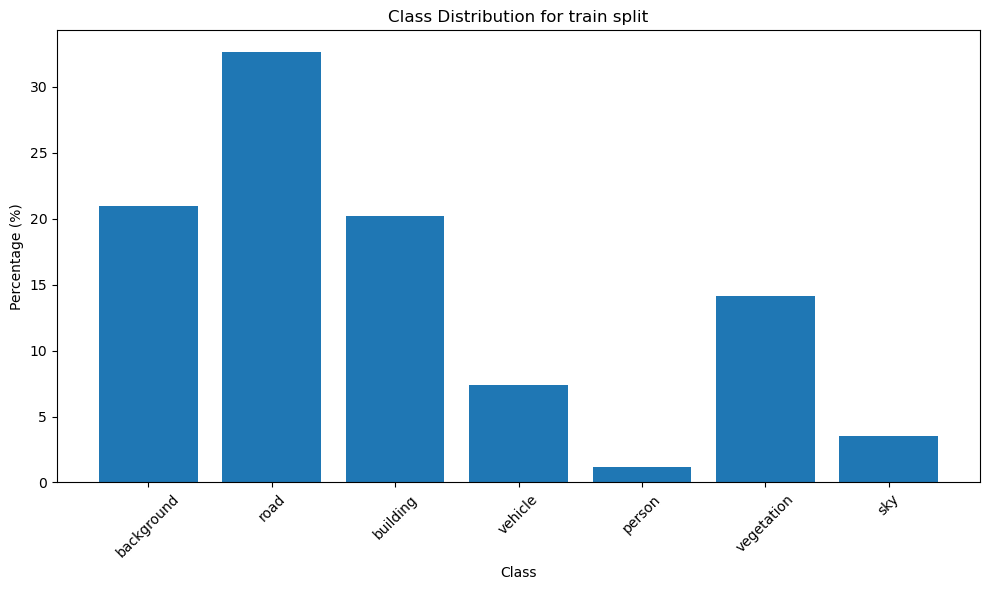

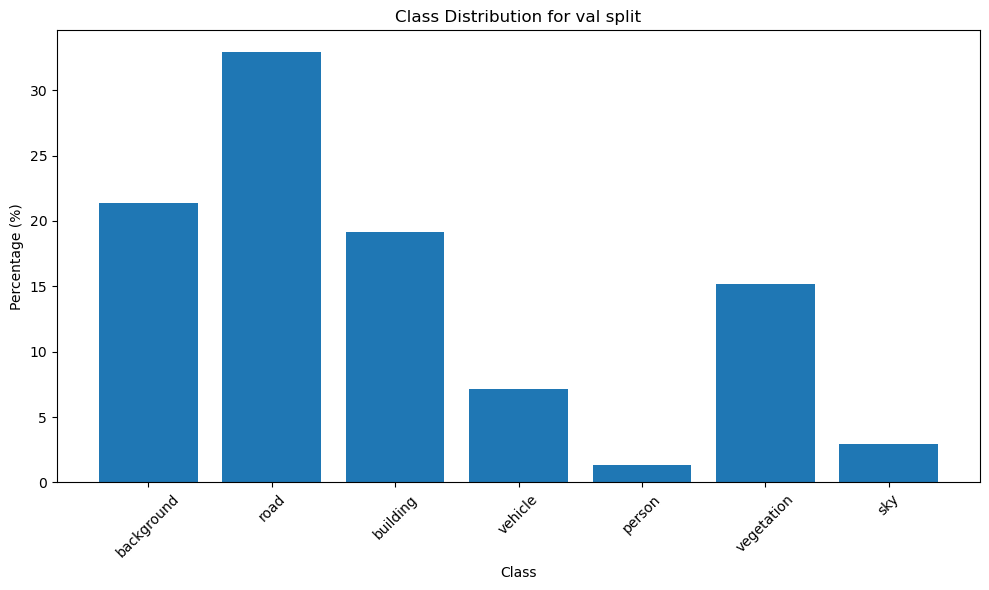

In [18]:
# Evaluate train split
train_metrics = evaluate_mask_remapping(output_dir, 'train')

# Evaluate validation split
val_metrics = evaluate_mask_remapping(output_dir, 'val')

# Compare distributions between splits
print("\nComparing train and validation splits:")
for cls in range(7):
    cls_str = str(cls)
    train_pct = train_metrics['class_percentage'].get(cls_str, 0)
    val_pct = val_metrics['class_percentage'].get(cls_str, 0)
    difference = abs(train_pct - val_pct)
    print(f"Class {cls}: Train {train_pct:.2f}%, Val {val_pct:.2f}%, Difference {difference:.2f}%")

In [ ]:
##Normalization and resizing##

In [33]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image

In [34]:
# Configuration (MODIFY THESE PATHS ACCORDING TO YOUR NOTEBOOK)
ORIGINAL_IMAGES_DIR = "C:/Users/subha/data/cityscapes/output/images/train"  # Raw images folder
ORIGINAL_MASKS_DIR = "C:/Users/subha/data/cityscapes/output/masks/train"   # Your custom masks folder
PROCESSED_IMAGES_DIR = "C:/Users/subha/data/cityscapes/output/Images_processed/Train"  # Where to save processed images
PROCESSED_MASKS_DIR = "C:/Users/subha/data/cityscapes/output/masks_processed/train"    # Where to save processed masks


In [36]:
# Create output directories if they don't exist
os.makedirs(PROCESSED_IMAGES_DIR, exist_ok=True)
os.makedirs(PROCESSED_MASKS_DIR, exist_ok=True)

In [37]:
def preprocess_and_save():
    # Get list of image files
    image_files = sorted([f for f in os.listdir(ORIGINAL_IMAGES_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))])
    TARGET_SIZE = (256, 256)
    for filename in tqdm(image_files, desc="Processing Train Images"):
        # Process Image
        img_path = os.path.join(ORIGINAL_IMAGES_DIR, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        
        # Normalize to [0,1]
        img_normalized = img_resized / 255.0
        
        # Save processed image
        output_img_path = os.path.join(PROCESSED_IMAGES_DIR, filename)
        np.save(output_img_path, img_normalized)  # Save as .npy for normalized float arrays
        
        
        # Process Corresponding Mask
        mask_path = os.path.join(ORIGINAL_MASKS_DIR, filename)
        if os.path.exists(mask_path):
            mask = np.array(Image.open(mask_path))
            mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)  # Preserve integer labels
            
            # Save mask
            output_mask_path = os.path.join(PROCESSED_MASKS_DIR, filename)
            Image.fromarray(mask_resized).save(output_mask_path)

if __name__ == "__main__":
    preprocess_and_save()
    print("Preprocessing completed! Processed data saved to:", PROCESSED_IMAGES_DIR, "and", PROCESSED_MASKS_DIR)

Processing Images: 100%|███████████████████████████████████████████████████████████| 2975/2975 [10:04<00:00,  4.92it/s]

Preprocessing completed! Processed data saved to: C:/Users/subha/data/cityscapes/output/Images_processed/Train and C:/Users/subha/data/cityscapes/output/masks_processed/train


In [38]:
# Configuration (MODIFY THESE PATHS ACCORDING TO YOUR NOTEBOOK)
ORIGINAL_IMAGES_DIR = "C:/Users/subha/data/cityscapes/output/images/val"  # Raw images folder
ORIGINAL_MASKS_DIR = "C:/Users/subha/data/cityscapes/output/masks/val"   # Your custom masks folder
PROCESSED_IMAGES_DIR = "C:/Users/subha/data/cityscapes/output/Images_processed/val"  # Where to save processed images
PROCESSED_MASKS_DIR = "C:/Users/subha/data/cityscapes/output/masks_processed/val"    # Where to save processed masks

In [40]:
# Create output directories if they don't exist
os.makedirs(PROCESSED_IMAGES_DIR, exist_ok=True)
os.makedirs(PROCESSED_MASKS_DIR, exist_ok=True)

In [41]:
def preprocess_and_save():
    # Get list of image files
    image_files = sorted([f for f in os.listdir(ORIGINAL_IMAGES_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))])
    
    for filename in tqdm(image_files, desc="Processing Test Images"):
        # Process Image
        img_path = os.path.join(ORIGINAL_IMAGES_DIR, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        
        # Normalize to [0,1]
        img_normalized = img_resized / 255.0
        
        # Save processed image
        output_img_path = os.path.join(PROCESSED_IMAGES_DIR, filename)
        np.save(output_img_path, img_normalized)  # Save as .npy for normalized float arrays
        
        
        # Process Corresponding Mask
        mask_path = os.path.join(ORIGINAL_MASKS_DIR, filename)
        if os.path.exists(mask_path):
            mask = np.array(Image.open(mask_path))
            mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)  # Preserve integer labels
            
            # Save mask
            output_mask_path = os.path.join(PROCESSED_MASKS_DIR, filename)
            Image.fromarray(mask_resized).save(output_mask_path)

if __name__ == "__main__":
    preprocess_and_save()
    print("Preprocessing completed! Processed data saved to:", PROCESSED_IMAGES_DIR, "and", PROCESSED_MASKS_DIR)

Processing Test Images: 100%|████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.40it/s]

Preprocessing completed! Processed data saved to: C:/Users/subha/data/cityscapes/output/Images_processed/val and C:/Users/subha/data/cityscapes/output/masks_processed/val
